<a href="https://colab.research.google.com/github/Smartsie/Playground/blob/master/Hands_on_Machine_Learning_Ex_1_Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import tarfile
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import plotly.express as px

In [4]:
!pip install shap

     |████████████████████████████████| 371 kB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509243 sha256=01711e643cc5136095d1b0e0b68ede18945b9a12b1282b659231114b3c481227
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [2]:
from yellowbrick.regressor import ResidualsPlot

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



In [3]:
!pip install 'umap-learn==0.3.10'
!pip install hdbscan

     |████████████████████████████████| 40 kB 5.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.3.10-py3-none-any.whl size=38883 sha256=2cf3f9a9e04da34d4a179e485456c0f2d84be47f4118b3f5146ebf77e5d7be49
  Stored in directory: /root/.cache/pip/wheels/ea/d0/8f/9e64bfc5ed0645f89b639196bef92daf5c704285133efce12f
Successfully built umap-learn
     |████████████████████████████████| 6.4 MB 5.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311903 sha256=7b88c206efeac00702e72fae8e9ab076db6ebc8e67f599489733abf941c969b3
  Stored in directory: /root/.cache/pip/wheels/73/5f/2f/9a259b84003b84847c259779206acecabb25ab56f1506ee72b
Successfully built hdbscan


In [6]:
DOWNLOAD_ROOT="https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH=os.path.join("datasets","housing")
HOUSING_URL=DOWNLOAD_ROOT+"datasets/housing/housing.tgz"

In [7]:
def fetch_housing_data(housing_url=HOUSING_URL,housing_path=HOUSING_PATH):
  os.makedirs(housing_path, exist_ok=True)
  tgz_path=os.path.join(housing_path,"housing.tgz")
  urllib.request.urlretrieve(housing_url,tgz_path)
  housing_tgz=tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()

In [8]:
def load_housing_data(housing_path=HOUSING_PATH):
  csv_path=os.path.join(housing_path,"housing.csv")
  return pd.read_csv(csv_path)

In [9]:
fetch_housing_data()
housing=load_housing_data()

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [11]:
housing['income_cat']=pd.cut(housing["median_income"],bins=[0.,1.5,3.0,4.5,6.,np.inf],
                             labels=[1,2,3,4,5])

In [12]:
split=StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=42)  
for train_index,test_index in split.split(housing,housing['income_cat']):
  strat_train_set=housing.loc[train_index]
  strat_test_set=housing.loc[test_index]

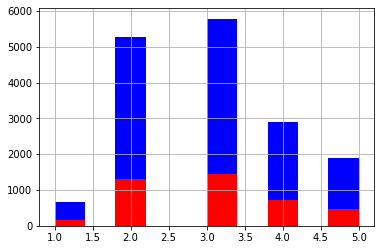

In [13]:
strat_train_set['income_cat'].hist(color='blue')
strat_test_set['income_cat'].hist(color='red')

In [14]:
for set_ in (strat_train_set,strat_test_set):
  set_.drop(['income_cat'],axis=1,inplace=True)

In [17]:
housing=strat_train_set.copy()

In [18]:
px.scatter_mapbox(housing,lat='latitude',lon='longitude',mapbox_style='open-street-map',size='population',color='median_house_value',opacity=0.4,width=800, height=600)

In [15]:
housing=strat_train_set.drop("median_house_value",axis=1)
housing_labels=strat_train_set['median_house_value']

In [16]:
housing_num=housing.drop('ocean_proximity',axis=1)
housing_cat=housing[['ocean_proximity']]

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin

In [18]:
rooms_ix,bedrooms_ix,population_ix, households_ix=3,4,5,6

In [19]:
class CombinedAttritubesAdder(BaseEstimator,TransformerMixin):
  def __init__(self, add_bedrooms_per_room=True):
    self.add_bedrooms_per_room=add_bedrooms_per_room
  def fit(self,X,y=None):
    return self # nothing else to do
  def transform(self,X):
    rooms_per_household=X[:,rooms_ix]/X[:,households_ix]
    population_per_household=X[:,population_ix]/X[:,households_ix]
    if self.add_bedrooms_per_room:
      bedrooms_per_room=X[:,bedrooms_ix]/X[:,rooms_ix]
      return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_room]
    else:
      return np.c_[X,rooms_per_household,population_per_household]


In [20]:
attr_adder=CombinedAttritubesAdder(add_bedrooms_per_room=False)

In [21]:
#housing_extra_attribs=attr_adder.transform(housing.values)

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [23]:
num_pipeline=Pipeline([
                       ('imputer',SimpleImputer(strategy='median')),
                       ('attribs_adder',CombinedAttritubesAdder()),
                       ('std_scaler',StandardScaler()),
])

In [24]:
housing_num=housing.drop('ocean_proximity',axis=1)
#housing_num_tr=num_pipeline.fit_transform(housing_num)

In [25]:
from sklearn.compose import ColumnTransformer
num_attribs=list(housing_num) # extracts columns names
cat_attribs=['ocean_proximity']
full_pipeline=ColumnTransformer([
                                 ("num",num_pipeline,num_attribs),
                                 ("cat",OneHotEncoder(),cat_attribs),
])
housing_prepared=full_pipeline.fit_transform(housing)

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [78]:
from sklearn.model_selection import cross_val_score
scores=cross_val_score(model, housing_prepared,housing_labels,scoring="neg_mean_squared_error",cv=10)

KeyboardInterrupt: ignored

In [52]:
model=Pipeline([
                ('full',full_pipeline),
                ('reg',DecisionTreeRegressor())
                ])

In [61]:
model=DecisionTreeRegressor()
model=RandomForestRegressor()
#model=KNeighborsRegressor(n_neighbors=10)
#model=LinearRegression()

model.fit(housing_prepared,housing_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
print(scores)

In [ ]:
import shap
#shap_values = shap.TreeExplainer(model).shap_values(housing_prepared)
#shap_values = shap.Explainer(model.predict).shap_values(housing)
shap_values = shap.explainers.Tree(model).shap_values(housing_prepared)

#shap.summary_plot(shap_values, housing_prepared, plot_type="bar")

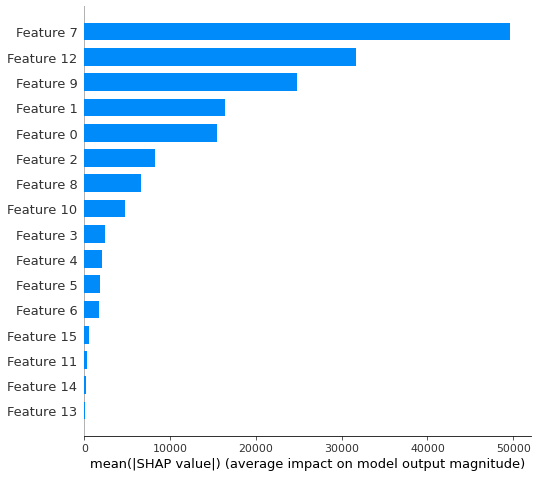

In [46]:
shap.summary_plot(shap_values, housing_prepared, plot_type="bar")

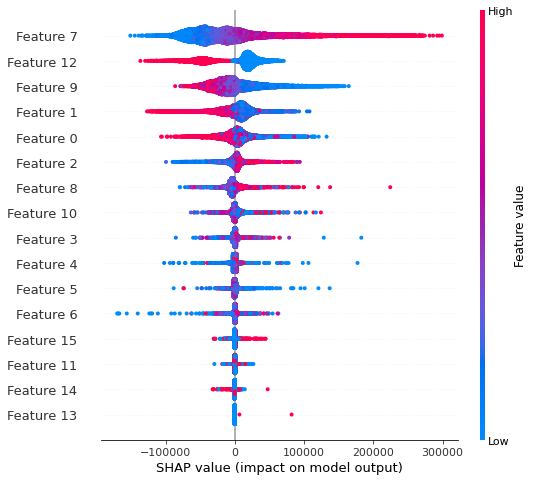

In [47]:
shap.summary_plot(shap_values, housing_prepared)

In [51]:
housing_prepared.shape

(16512, 16)

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid=[
            {'n_estimators':[3,10,30],
             'max_features':[2,4,6,8]},
            {'bootstrap':[False],'n_estimators':[3,10],
             'max_features':[2,3,4]},
]

In [ ]:
forest_reg=RandomForestRegressor()

In [ ]:
grid_search=GridSearchCV(forest_reg,param_grid,cv=5,scoring='neg_mean_squared_error',return_train_score=True)

In [ ]:
grid_search.fit(housing_prepared,housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [ ]:
final_model=grid_search.best_estimator_

In [59]:
final_model=model

In [60]:
X_test=strat_test_set.drop("median_house_value",axis=1)
y_test=strat_test_set['median_house_value']
X_test_prepared=full_pipeline.transform(X_test)

In [61]:
final_prediction=final_model.predict(X_test_prepared)

In [62]:
final_mse=mean_squared_error(y_test, final_prediction)
final_rmse=np.sqrt(final_mse)

In [63]:
print(final_rmse)

58843.44065555195


AttributeError: ignored

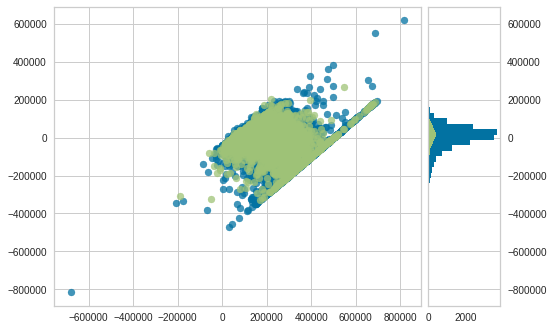

In [72]:
visualizer = ResidualsPlot(model)

visualizer.fit(housing_prepared,housing_labels)  # Fit the training data to the visualizer
visualizer.score(X_test_prepared, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

In [ ]:
# Feature importance analysis
import shap
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")